In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [6]:
# Import the data
df = pd.read_csv('oil and gas.csv')

# View the first 5 rows
df.head(10)

,Symbol,Date,Open,High,Low,Close,Volume,Currency
0,Brent Oil,2000-01-04,23.90,24.70,23.89,24.39,32509,USD
1,Brent Oil,2000-01-05,24.25,24.37,23.70,23.73,30310,USD
2,Brent Oil,2000-01-06,23.55,24.22,23.35,23.62,44662,USD
3,Brent Oil,2000-01-07,23.57,23.98,23.05,23.09,34826,USD
4,Brent Oil,2000-01-10,23.04,23.78,23.04,23.73,26388,USD
5,Brent Oil,2000-01-11,23.90,24.67,23.83,24.62,17410,USD
6,Brent Oil,2000-01-12,24.35,25.10,23.97,24.81,28455,USD
7,Brent Oil,2000-01-13,24.84,25.25,24.70,24.98,22307,USD
8,Brent Oil,2000-01-14,24.98,25.56,24.98,25.47,8822,USD
9,Brent Oil,2000-01-17,25.55,25.75,25.42,25.65,16286,USD


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23024 entries, 0 to 23023
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Symbol    23024 non-null  object 
 1   Date      23024 non-null  object 
 2   Open      23024 non-null  float64
 3   High      23024 non-null  float64
 4   Low       23024 non-null  float64
 5   Close     23024 non-null  float64
 6   Volume    23024 non-null  int64  
 7   Currency  23024 non-null  object 
dtypes: float64(4), int64(1), object(3)
memory usage: 1.4+ MB


In [8]:
# View unique values in the 'Symbol' column
print("Unique Symbols:")
print(df['Symbol'].unique())

# View unique values in the 'Currency' column
print("\nUnique Currencies:")
print(df['Currency'].unique())

Unique Symbols:
['Brent Oil' 'Crude Oil WTI' 'Natural Gas' 'Heating Oil']

Unique Currencies:
['USD']


In [9]:
# 1. Convert the 'Date' column to datetime type
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# 2. Filter for Brent Oil only
df = df[df['Symbol'] == 'Brent Oil'].reset_index(drop=True)

# 3. Remove the 'Currency' column
df = df.drop(columns=['Currency'])

# 4. Extract the year, month, and day as separate columns
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day

# Reorder columns to place Year, Month, Day beside Date
df = df[['Date', 'Year', 'Month', 'Day', 'Symbol', 'Open', 'High', 'Low', 'Close', 'Volume']]

# 5. Calculate 7-day rolling average for 'Open' price and 'Volume'
df['Price_Rolling_Avg_7'] = df['Open'].rolling(window=7).mean()
df['Volume_Rolling_Avg_7'] = df['Volume'].rolling(window=7).mean()

# 6. Calculate daily returns
df['Daily_Return'] = df['Close'].pct_change()

# 7. Calculate 7-day rolling volatility (standard deviation of daily returns)
df['Volatility_7D'] = df['Daily_Return'].rolling(window=7).std()

# 8. Create lag features (-1 day, -2 days, -3 days) for 'Open' price
df['Open_Lag_1'] = df['Open'].shift(1)
df['Open_Lag_2'] = df['Open'].shift(2)
df['Open_Lag_3'] = df['Open'].shift(3)

# Display the updated DataFrame
print(df.head())

        Date  Year  Month  Day     Symbol   Open   High    Low  Close  Volume  \
0 2000-01-04  2000      1    4  Brent Oil  23.90  24.70  23.89  24.39   32509   
1 2000-01-05  2000      1    5  Brent Oil  24.25  24.37  23.70  23.73   30310   
2 2000-01-06  2000      1    6  Brent Oil  23.55  24.22  23.35  23.62   44662   
3 2000-01-07  2000      1    7  Brent Oil  23.57  23.98  23.05  23.09   34826   
4 2000-01-10  2000      1   10  Brent Oil  23.04  23.78  23.04  23.73   26388   

   Price_Rolling_Avg_7  Volume_Rolling_Avg_7  Daily_Return  Volatility_7D  \
0                  NaN                   NaN           NaN            NaN   
1                  NaN                   NaN     -0.027060            NaN   
2                  NaN                   NaN     -0.004635            NaN   
3                  NaN                   NaN     -0.022439            NaN   
4                  NaN                   NaN      0.027718            NaN   

   Open_Lag_1  Open_Lag_2  Open_Lag_3  
0         

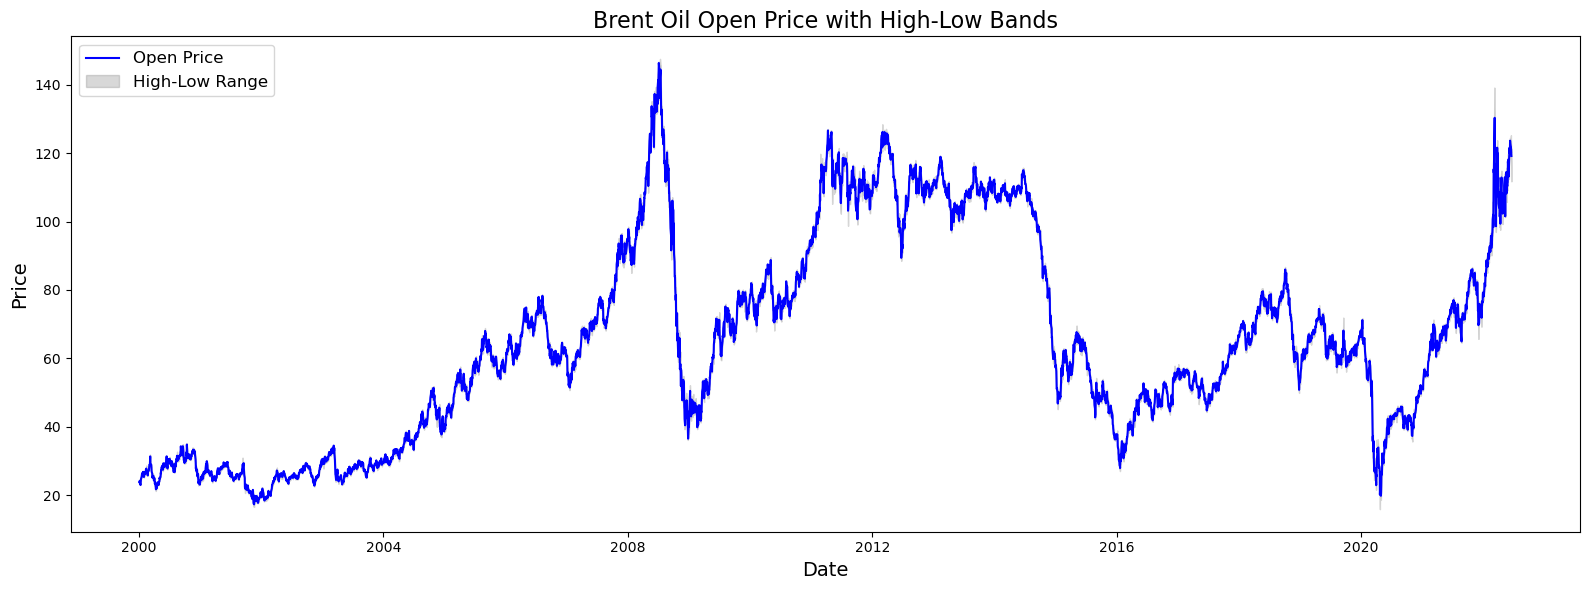

In [11]:
# Plot Open Price with High-Low Bands
plt.figure(figsize=(16, 6))
plt.plot(df['Date'], df['Open'], label='Open Price', color='blue', lw=1.5)
plt.fill_between(df['Date'], df['Low'], df['High'], color='gray', alpha=0.3, label='High-Low Range')

# Add title and labels
plt.title("Brent Oil Open Price with High-Low Bands", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Price", fontsize=14)
plt.legend(loc='upper left', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

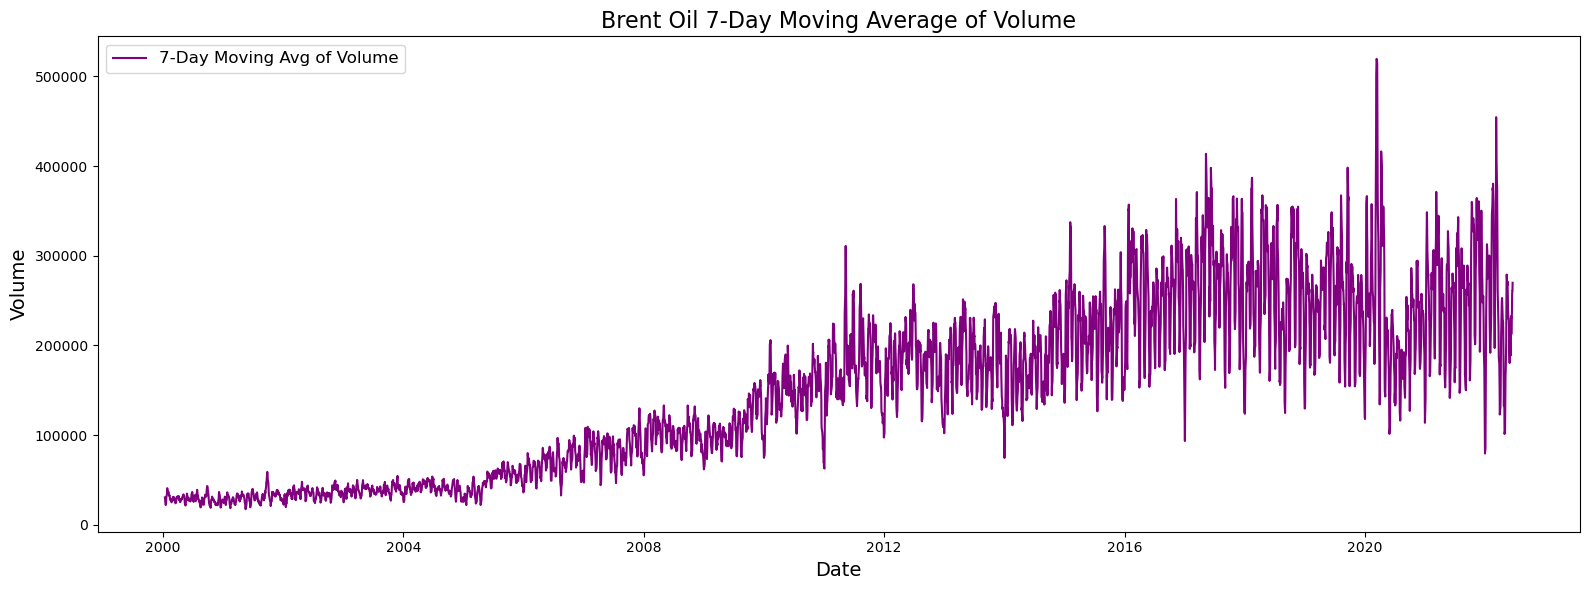

In [13]:
# Plot 7-Day Rolling Average of Volume (already in df['Volume_Rolling_Avg_7'])
plt.figure(figsize=(16, 6))
plt.plot(df['Date'], df['Volume_Rolling_Avg_7'], label='7-Day Moving Avg of Volume', color='purple', lw=1.5)

# Add title and labels
plt.title("Brent Oil 7-Day Moving Average of Volume", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Volume", fontsize=14)
plt.legend(loc='upper left', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

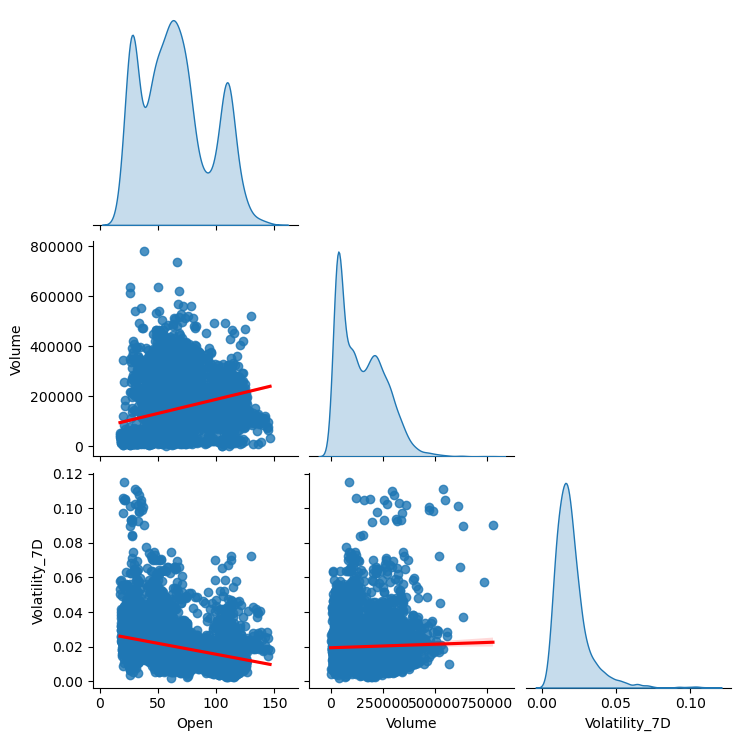

In [18]:
# Selecting relevant numerical features for the pairplot
features = ['Open', 'Volume','Volatility_7D']

# Drop NaN values to avoid errors in plotting
df_cleaned = df[features].dropna()

# Create the pairplot
sns.pairplot(df_cleaned, diag_kind='kde', corner=True, kind='reg', plot_kws={'line_kws':{'color':'red'}})

# Show the plot
plt.show()

# Different Models

In [51]:
# Convert Date to datetime and sort
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date")

# Convert Date to numerical format (ordinal)
df["Date"] = df["Date"].map(pd.Timestamp.toordinal)

# Select only Date and Close price
data = df[["Date", "Close"]].values

# Scale Close price
scaler = MinMaxScaler()
data[:, 1] = scaler.fit_transform(data[:, 1].reshape(-1, 1)).flatten()

In [52]:
# Function to create sequences
def create_sequences(data, seq_length=30):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 1])  # Only Close price
        y.append(data[i, 1])  # Next day's Close price
    return np.array(X), np.array(y)

In [53]:
# Set sequence length
seq_length = 30
X, y = create_sequences(data, seq_length)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)  # (batch, seq_len, feature_dim)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)  # (batch, 1)

# Train-test split
train_size = int(0.8 * len(X_tensor))
X_train, X_test = X_tensor[:train_size], X_tensor[train_size:]
y_train, y_test = y_tensor[:train_size], y_tensor[train_size:]

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

In [54]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)  # Output price

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])  # Take last output from LSTM
        return out

# Initialize model
model = LSTMModel()
criterion = nn.MSELoss()  # MSE loss for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

In [55]:
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Prevent exploding gradients
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.6f}")

Epoch 1/20, Loss: 0.022608
Epoch 2/20, Loss: 0.001670
Epoch 3/20, Loss: 0.001559
Epoch 4/20, Loss: 0.001604
Epoch 5/20, Loss: 0.001473
Epoch 6/20, Loss: 0.001532
Epoch 7/20, Loss: 0.001506
Epoch 8/20, Loss: 0.001497
Epoch 9/20, Loss: 0.001482
Epoch 10/20, Loss: 0.001459
Epoch 11/20, Loss: 0.001448
Epoch 12/20, Loss: 0.001400
Epoch 13/20, Loss: 0.001410
Epoch 14/20, Loss: 0.001409
Epoch 15/20, Loss: 0.001404
Epoch 16/20, Loss: 0.001428
Epoch 17/20, Loss: 0.001390
Epoch 18/20, Loss: 0.001349
Epoch 19/20, Loss: 0.001357
Epoch 20/20, Loss: 0.001334
